# Problem 2

In [85]:
import pandas as pd
import sqlite3
import zipfile
import tempfile
import os

zip_path = 'mock_resq.db.zip'
db_name = 'mock_resq.db'

class TempDirWrapper:
    """Wrapper for temporary extraction of database zipfile
    """
    
    def __init__(self, zip_path:str, db_name:str):
        self.zip_path = zip_path
        self.db_name = db_name
        self.temp_dir = None
        self.db_path = None

    def __enter__(self) -> str:
        self.temp_dir = tempfile.TemporaryDirectory()
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.temp_dir.name)
            self.db_path = os.path.join(self.temp_dir.name, self.db_name)
            return self.db_path
        except Exception as e:
            self.__exit__(None, None, e)
            raise

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.temp_dir:
            self.temp_dir.cleanup()
            
with TempDirWrapper(zip_path=zip_path, db_name=db_name) as db_path:
    # Use db_path here
    with sqlite3.connect(db_path) as conn:
        users = pd.read_sql_query(sql="SELECT * FROM users;", con=conn)
        orders = pd.read_sql_query(sql="SELECT * FROM orders", con=conn)
        providers = pd.read_sql_query(sql="SELECT * FROM providers", con=conn)
        
        
users.registeredDate = pd.to_datetime(users.registeredDate)
users.country = users.country.astype(dtype="category")
users = users.rename(columns={"id": "userId"})

orders.createdAt = pd.to_datetime(orders.createdAt)
for col in ["quantity", "refunded", "sales"]:
    orders[col] = pd.to_numeric(orders[col])

# Lets keep the ids as string. Otherwise there will be problems in joining. 
orders.providerId = orders.providerId.astype(str)
orders = orders.rename(columns={"id": "orderId"})

# Here we joining with right specification since there might be users that have no orders. 
orders = orders.merge(right=users, on="userId", how="right")
orders.createdAt = orders.createdAt.fillna(max(orders.createdAt))
orders["t1"]  = (orders.createdAt - orders.registeredDate).dt.days
orders = orders.sort_values(["userId", "t1"]).reset_index(drop=True)
orders["t0"] = orders.groupby(["userId"]).t1.shift(1).fillna(0)
orders["duration"] = orders["t1"] - orders["t0"]
orders["order_no"] = orders.groupby(["userId"]).cumcount() + 1

providers = providers.rename(columns={
    "id":"providerId", 
    "country":"providerCountry"
    })
providers.providerId = providers.providerId.astype(str)
providers.defaultOfferType = providers.defaultOfferType.astype("category")
orders = orders.merge(providers[["providerId", "defaultOfferType","providerCountry"]], on = "providerId", how="left")

## Average Purchase Value (APV)



$$
    \text{APV} = \frac{\text{Total Revenue}}{\text{Number of Orders}}
$$

In [86]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

1
2
3


Text(0.5, 0, 'Months')

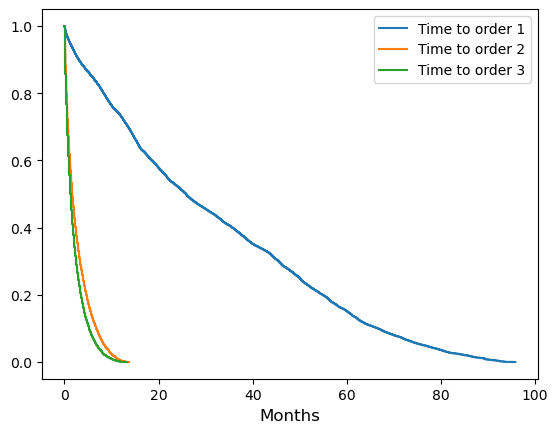

In [87]:
est_data = orders.query("order_no <= 3")
ax = plt.subplot(111)
for order_n in est_data.order_no.unique():
    print(order_n)
    kmf = KaplanMeierFitter()
    ax = kmf.fit(
        durations = est_data.query(f"order_no == {order_n}").duration*12 / 365, 
        event_observed = est_data.query(f"order_no == {order_n}").duration != 0, 
        label = f"Time to order {order_n}"
        ).plot_survival_function(ax=ax)
plt.xlabel(xlabel='Months', fontsize=12)

fin
swe
est
deu


Text(0.5, 0, 'Months')

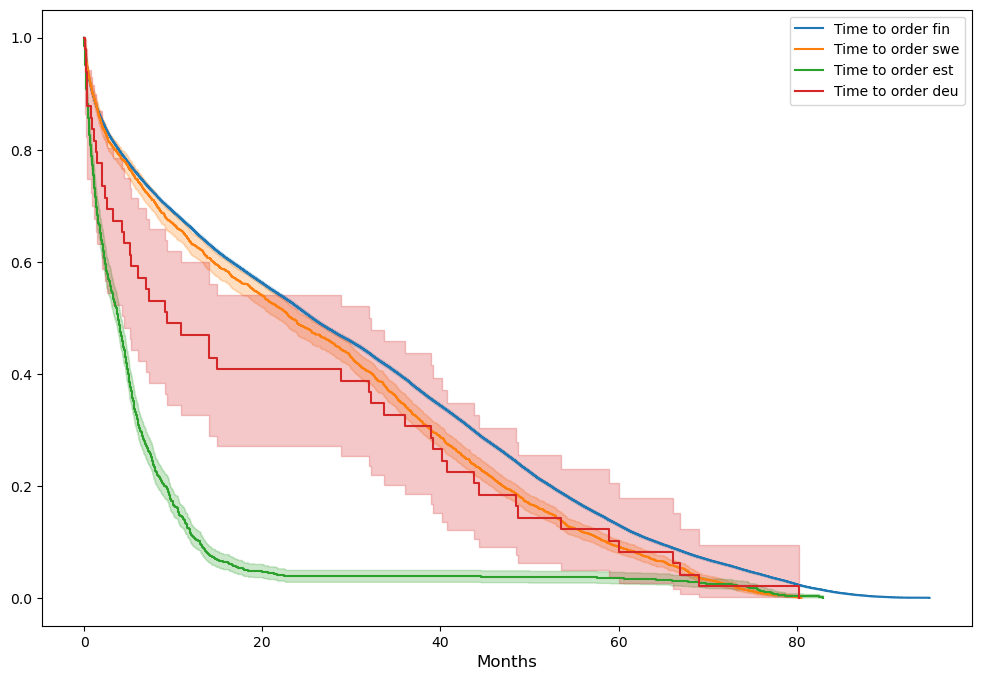

In [88]:
est_data = orders.query("(order_no == 1) & (defaultOfferType=='meal')").dropna()
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for country in est_data.providerCountry.unique():
    print(country)
    kmf = KaplanMeierFitter()
    ax = kmf.fit(
        durations = est_data.query(f"providerCountry == '{country}'").duration*12 / 365, 
        event_observed = est_data.query(f"providerCountry == '{country}'").duration != 0, 
        label = f"Time to order {country}"
        ).plot_survival_function(ax=ax)
plt.xlabel(xlabel='Months', fontsize=12)

fin
est


Text(0.5, 0, 'Months')

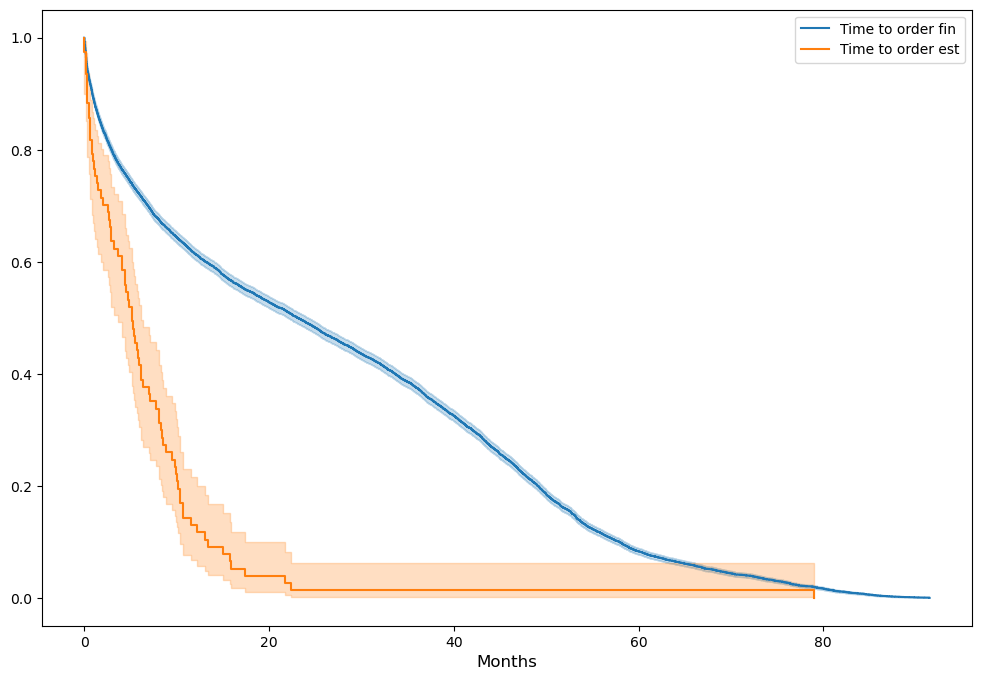

In [95]:
est_data = orders.query("(order_no == 1) & (defaultOfferType=='grocery-bag') & (providerCountry != 'swe')").dropna()
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                       
for country in est_data.providerCountry.unique():
    print(country)
    kmf = KaplanMeierFitter()
    ax = kmf.fit(
        durations = est_data.query(f"providerCountry == '{country}'").duration*12 / 365, 
        event_observed = est_data.query(f"providerCountry == '{country}'").duration != 0, 
        label = f"Time to order {country}"
        ).plot_survival_function(ax=ax)
plt.xlabel(xlabel='Months', fontsize=12)

Preparing the data for Accelerated Failure time regression:

In [96]:
est_dta = orders.dropna(subset="sales").query("(currency != 'swe')")
est_dta = est_dta[["duration", "providerCountry","order_no","sales","quantity", "defaultOfferType"]]
est_dta.providerCountry = est_dta.providerCountry.astype("str")

# generating indicator for the provider's country
est_dta["fin"] = (est_dta.providerCountry == "fin").astype(int)
est_dta["est"] = (est_dta.providerCountry == "est").astype(int)

# generating indicator for the Offer Type
est_dta["meal"] = (est_dta.defaultOfferType == "meal").astype(int)
est_dta["grocery_bag"] = (est_dta.defaultOfferType == "grocery-bag").astype(int)

# generating indicator for the order number. 
est_dta["order_1"] = (est_dta.order_no == 1).astype(int)
est_dta["order_2"] = (est_dta.order_no == 2).astype(int)


est_dta = est_dta.drop(columns=["order_no","providerCountry","defaultOfferType"])

est_dta["event"] = 1
est_dta["sales"] = est_dta["sales"] /100
est_dta.loc[est_dta.duration == 0, "duration"] = 1
est_dta.describe().round(2)


,duration,sales,quantity,fin,est,meal,grocery_bag,order_1,order_2,event
count,299971.00,299971.00,299971.00,299971.00,299971.00,299971.00,299971.00,299971.00,299971.00,299971.0
mean,383.68,7.70,1.34,0.97,0.02,0.73,0.09,0.41,0.19,1.0
std,619.52,15.06,0.78,0.18,0.12,0.44,0.29,0.49,0.39,0.0
min,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
25%,15.00,3.50,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.0
50%,65.00,5.50,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.0
75%,416.00,8.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.0
max,2887.00,1025.00,30.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


In [97]:
from lifelines import WeibullAFTFitter
aft = WeibullAFTFitter()
aft.fit(est_dta, duration_col='duration', event_col='event')

aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 299971 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
   number of observations = 299971
number of events observed = 299971
           log-likelihood = -1817906.67
         time fit was run = 2024-10-06 13:48:54 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                    
lambda_ est         -0.56      0.57      0.03           -0.62           -0.50                0.54                0.61
        fin          0.19      1.21      0.02            0.15            0.24                1.16                1.27
        grocery_bag -0.11      0.89      0.01           -0.13           -0.09                0.88                0.91
        meal        -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
        order_1      3.02     20.43      0.00            3.01            3.03               20.23               20.63
        order_2      0.61      1.83      0.01            0.59            0.62                1.81                1.86
        quantity     0.00      1.00      0.00           -0.00            0.01                1.00                1.01
        sales        0.00      1.00      0.00            0.00            0.00                1.00                1.00
        Intercept    3.47     32.16      0.03            3.42            3.52               30.60               33.79
rho_    Intercept   -0.20      0.82      0.00           -0.21           -0.20                0.81                0.82

                     cmp to       z      p  -log2(p)
param   covariate                                   
lambda_ est            0.00  -18.20 <0.005    243.36
        fin            0.00    7.93 <0.005     48.68
        grocery_bag    0.00  -12.27 <0.005    112.52
        meal           0.00   -4.73 <0.005     18.76
        order_1        0.00  604.07 <0.005       inf
        order_2        0.00   96.94 <0.005       inf
        quantity       0.00    0.73   0.47      1.10
        sales          0.00    9.83 <0.005     73.28
        Intercept      0.00  137.36 <0.005       inf
rho_    Intercept      0.00 -137.72 <0.005       inf
---
Concordance = 0.70
AIC = 3635833.34
log-likelihood ratio test = 237812.90 on 8 df
-log2(p) of ll-ratio test = inf